### The purpose of this workbook is to...

...complete the technical task by bringing in tables from db

#### Overview:

<p>1) Some Exploratory Analysis
<p>2) Cleaning/Reshaping/Aggregating (Any Data Manipulation Needed)
<p>3) Generate answers to technical task questions

<p>---

In [1]:
# load packages, connect to db
import sqlite3
import pandas as pd
import numpy

pd.options.display.max_rows = 50

con = sqlite3.connect("techtask.db")
cur = con.cursor()

In [2]:
# just a sample for exploration

complaints_eda = pd.read_sql_query("SELECT * FROM complaints LIMIT 1000",con)

In [3]:
complaints_eda.head()

# looks like most relevant cols to the task are incident_zip and agency. 
# agency name, too, but agency appears to be superior to it. 
# next: unique vals...

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,...,vehicle_type,taxi_company_borough,taxi_pick_up_location,bridge_highway_name,bridge_highway_direction,road_ramp,bridge_highway_segment,latitude,longitude,location
0,39410091,06/08/2018 02:19:00 PM,06/09/2018 02:20:00 PM,DEP,Department of Environmental Protection,Lead,Lead Kit Request (Residential) (L10),None,11213.0,1738 PRESIDENT STREET,...,None,None,None,None,None,None,None,40.666908,-73.929424,"(40.66690844742622, -73.92942429969591)"
1,39561395,06/25/2018 04:32:00 PM,06/25/2018 04:32:50 PM,HRA,HRA Benefit Card Replacement,Benefit Card Replacement,Medicaid,NYC Street Address,NaN,None,...,None,None,None,None,None,None,None,NaN,NaN,None
2,40271310,09/13/2018 03:25:00 PM,09/15/2018 12:00:00 AM,DSNY,Department of Sanitation,Request Large Bulky Item Collection,Request Large Bulky Item Collection,Sidewalk,11238.0,63 CAMBRIDGE PLACE,...,None,None,None,None,None,None,None,40.685361,-73.963175,"(40.6853608541348, -73.96317539059956)"
3,39410065,06/08/2018 12:50:00 PM,06/08/2018 06:15:00 PM,DEP,Department of Environmental Protection,Sewer,Catch Basin Clogged/Flooding (Use Comments) (SC),None,11422.0,None,...,None,None,None,None,None,None,None,40.656391,-73.730730,"(40.656390609012185, -73.7307304699295)"
4,40026127,08/16/2018 09:11:00 AM,08/17/2018 12:00:00 PM,DSNY,BCC - Brooklyn South,Derelict Bicycle,14B Derelict Bicycle,Street,11219.0,4501 NEW UTRECHT AVENUE,...,None,None,None,None,None,None,None,40.639718,-73.994347,"(40.639718190117414, -73.99434658865864)"


In [4]:
# unique zips - I detected some uncleanliness here. Going to do a more thorough check...

unique_zips = pd.read_sql_query("SELECT incident_zip \
                                from complaints \
                                WHERE LENGTH(incident_zip) <> 5 \
                                LIMIT 1000",
                                con)

unique_zips.incident_zip.value_counts()

7114          219
83            141
0             138
7024           16
7302           16
7030           15
7086           14
7310           14
7304           13
7094           12
7087            9
7093            9
7073            8
UNKNOWN         8
7047            8
7306            8
6902            7
7102            7
7601            7
7054            7
29616-0759      4
7012            4
7307            4
NJ 07114        4
7305            4
             ... 
8021            1
HARRISBURG      1
35210-6928      1
8527            1
327500          1
8520            1
7067            1
N/              1
NJ              1
1850            1
8505            1
32896-5004      1
7974            1
7430            1
1000            1
78265-9707      1
7458            1
92046-3023      1
7960            1
14221-7820      1
19801-5148      1
6462430478      1
11434-420       1
1801            1
08540-1515      1
Name: incident_zip, Length: 262, dtype: int64

^^^Ah, yes. Those are potentially problematic. An additional problem is that a full recovery effort isn't totally feasible for me locally given the size of the table. What I'll have to do is use the `nyc_zips` table to exclude any of the above-type values, though that's not ideal. If I had more resources, I could potential pursue a clean-up effort like the following:

<p>
```
test_re = pd.DataFrame({"zip_code":["10001"," NYC 10001","10001-1001","UNKNOWN"]})
test_re.zip_code = test_re.zip_code.str.replace("[^0-9]","")
test_re.zip_code.str.slice(0,5)```
    
<p>Just going to go for an inner join below for now...

In [5]:
# ok...aggregating the full complaints
complaints_agg_query = "SELECT \
                        t1.incident_zip, \
                        t2.borough, \
                        t1.agency, \
                        COUNT(*) AS complaint_count \
                        \
                        FROM complaints t1 \
                        \
                        INNER JOIN nyc_zips t2 \
                        \
                        ON t1.incident_zip = t2.zip_code \
                        \
                        GROUP BY \
                        t1.incident_zip,\
                        t1.agency"

complaints = pd.read_sql_query(complaints_agg_query,con=con)

In [6]:
# quick checks to make sure things check out - uniqueness should be incident+borough - agency

# cast this field as string before moving on
complaints.incident_zip = complaints.incident_zip.apply(str)

#complaints.head()
#complaints.complaint_count.sum() # this is encouraging - didn't sacrifice too much

In [7]:
# ok, now going to reshape long->wide to do later comparisons

complaints_piv = complaints.pivot_table(
         
         index=['incident_zip', 'borough'], 
         columns='agency', 
         values='complaint_count'
    
).reset_index()

# clean up cols a bit
complaints_piv.index.name = complaints_piv.columns.name = None

complaints_piv.head()

# quick clean-up: if a zip+borough doesn't have complaints for an agency, consider that zero
complaints_piv = complaints_piv.fillna(0) 

complaints_piv.head()

,incident_zip,borough,3-1-1,DCA,DEP,DFTA,DHS,DOB,DOE,DOF,...,DOT,DPR,DSNY,EDC,FDNY,HPD,HRA,NYCEM,NYPD,TLC
0,10001,Manhattan,138.0,2733.0,14589.0,269.0,5014.0,4880.0,23.0,1352.0,...,9604.0,1410.0,5339.0,92.0,0.0,8330.0,0.0,0.0,18870.0,7638.0
1,10002,Manhattan,219.0,1528.0,13792.0,585.0,1149.0,6370.0,215.0,2051.0,...,19282.0,4939.0,12161.0,177.0,0.0,28782.0,0.0,0.0,45626.0,4681.0
2,10003,Manhattan,262.0,1623.0,18609.0,301.0,6109.0,6015.0,116.0,3115.0,...,17189.0,4163.0,9028.0,199.0,0.0,23230.0,0.0,0.0,32741.0,8881.0
3,10004,Manhattan,21.0,541.0,2809.0,26.0,505.0,499.0,29.0,346.0,...,4762.0,586.0,459.0,54.0,0.0,293.0,0.0,0.0,3550.0,1137.0
4,10005,Manhattan,61.0,424.0,3263.0,12.0,498.0,529.0,0.0,550.0,...,4795.0,150.0,488.0,22.0,0.0,375.0,0.0,0.0,4448.0,1012.0


At this point, we're on our way to getting the task items complete. Out of interest, I'd like to do one viz before moving on that might inform the approach to answering the task items. I'd like to gauge similarities/differences across zips+boroughs, and one way of doing that that captures all of the agencies is via a parallel coordinates plot. It probably won't be the prettiest, most useful viz, but there might be some interesting tidbits. Doing that below...

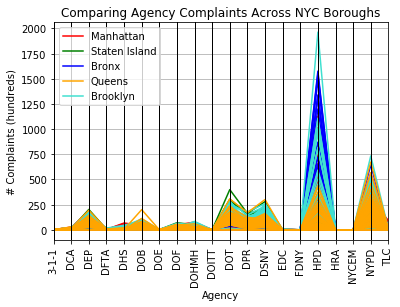

In [10]:
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt
%matplotlib inline

# make a plot df that facilitates a cleaner plot
complaints_plot_df = complaints_piv.iloc[:,1:]
complaints_plot_df.iloc[:,1:] = complaints_plot_df.iloc[:,1:].apply(lambda v: v/100,axis=1)

ax = parallel_coordinates(complaints_plot_df,
                          "borough",
                          color=['red','green','blue','orange','turquoise'])

# some quick plot cleaning
for label in ax.xaxis.get_ticklabels():
    label.set_rotation(90)

ax.legend(loc=2)

plt.ylabel("# Complaints (hundreds)")
plt.xlabel("Agency")
plt.title("Comparing Agency Complaints Across NYC Boroughs")
plt.show()

Hmm. Definitely some interesting bits, but the plot needs some work. I'll move on to the task items and return to this later on. 

### Part I - Data Analysis Tasks

For organization's sake, I will build a class with different pieces of functionality for calling out the answers to the different task items. The first item is straightforward enough: I will subset the main table just to display the values for the test zips. 

**A quick preface on the second item:** I recognize I'm applying for a Data Engineer position, not a Data Scientist one. As such, I won't spend so much time on the "science" for this piece. It's definitely something I'm interested in, happy to talk about it more, but I will focus on the engineering piece for now. 

For the second item, my initial thought was to do KNN and adapt it just to find the one closest and one farthest. That is basically what is implemented below, what I call the `lazy_neighbor`. It is called such since it calculates the distances between points, but it doesn't really have the second piece where `k` comes into play like it does in traditional KNN models. I'll start by using Euclidean distance as scipy's documentation defines it: 

https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.euclidean.html

I'd also like to try out Manhattan in case outliers become an issue (again, not going to spend much time here. If this were a DS application, I'd definitely do some more formal testing...). scipy's documentation: 

https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.distance.cityblock.html

In [11]:
from scipy.spatial import distance

# 10011, 11217 are test zips

class TaskManager:
    
    def __init__(self,df,test_zip,distance_type):
        
        self.df = df
        self.test_zip = test_zip
        self.distance_type = distance_type
        
    def t1_display_vals(self):
        
        # task 1: display the complaint counts for a test zip
        to_print_df = self.df[self.df['incident_zip']==self.test_zip]

        # quick clean-ups
        to_print_df = pd.melt(to_print_df, 
                              id_vars=['incident_zip','borough'], 
                              value_vars=to_print_df.columns[2:])
        
        to_print_df = to_print_df.iloc[:,2:]
        to_print_df.value = to_print_df.value.apply(str)
        to_print_df.columns = ['Department',"N Complaints"]
        
        print("ZIP code " + self.test_zip + "'s Complaint Counts By Department...")
        print(to_print_df.to_string(index=False))

    def t2_lazy_neighbor(self):

        # task 2: find the most and least similar zips by complaint counts
        # subset data

        test_df = self.df[self.df["incident_zip"]==self.test_zip]

        # now exclude that value from the main df for comparisons
        mask = self.df['incident_zip'].isin([self.test_zip])
        train_df = self.df[~mask]

        # create vars needed for loop comparisons

        all_distances = {} # for return values
        test_vector = test_df.iloc[0][2:] # format numeric cols as vector for matmul

        # do the loop

        for r in range(len(train_df)): 

            # create the train vector for each row
            train_vector = train_df.iloc[r][2:]

            # calc euclidean distances
            if self.distance_type == "euclidean":
            
                dist = distance.euclidean(train_vector,test_vector)
            
            elif self.distance_type == "manhattan": 
                
                dist = distance.cityblock(train_vector,test_vector)

            # store dist value in dict with train indices
            all_distances[r] = dist

        # output
        # find the names of the closest and farthest
        closest_index = min(all_distances.keys(), 
                        key=(lambda key: all_distances[key]))

        farthest_index  = max(all_distances.keys(), 
                          key=(lambda key: all_distances[key]))

        # simple print output

        closest_zip = train_df.iloc[closest_index][0]
        farthest_zip = train_df.iloc[farthest_index][0]

        print("ZIP code most similar to " + self.test_zip + ": " + closest_zip)
        print("ZIP code least similar to " + self.test_zip + ": " + farthest_zip)

        # plot, too - get all values for found zips

        closest_zip_df = train_df[train_df['incident_zip']==closest_zip]
        farthest_zip_df = train_df[train_df['incident_zip']==farthest_zip]

        # add a label col to all
        
        test_df.insert(2, 'label',"Test ZIP (" + self.test_zip + ")")
        closest_zip_df.insert(2,'label',"Most Similar (" + closest_zip + ")")
        farthest_zip_df.insert(2,'label',"Least Similar (" + farthest_zip + ")")

        plot_df = pd.concat([test_df,
                            closest_zip_df,
                            farthest_zip_df])

        ### pLoT ###
        ax = parallel_coordinates(plot_df.iloc[:,2:], # subset out string cols when plotting
                             'label')

        # add plot params

        for label in ax.xaxis.get_ticklabels():
            label.set_rotation(90)

        ax.legend(loc=2)

        plt.ylabel("# Complaints")
        plt.xlabel("Agency")
        plt.title("Comparing Agency Complaints Against " + self.test_zip)

        plt.show()


In [12]:
# create managers

test_10011 = TaskManager(df = complaints_piv,
                        test_zip = "10011",
                        distance_type = 'euclidean')

test_11217 = TaskManager(df = complaints_piv,
                         test_zip = "11217",
                         distance_type = 'euclidean')

In [13]:
# 10011
test_10011.t1_display_vals()

ZIP code 10011's Complaint Counts By Department...
Department N Complaints
    3-1-1        171.0
      DCA       1288.0
      DEP      18177.0
     DFTA        378.0
      DHS       4001.0
      DOB       6201.0
      DOE        157.0
      DOF       3782.0
    DOHMH       4729.0
    DOITT        105.0
      DOT      12877.0
      DPR       5312.0
     DSNY       9307.0
      EDC        229.0
     FDNY          0.0
      HPD      20485.0
      HRA          0.0
    NYCEM          0.0
     NYPD      23226.0
      TLC       5935.0


ZIP code most similar to 10011: 10016
ZIP code least similar to 10011: 11226


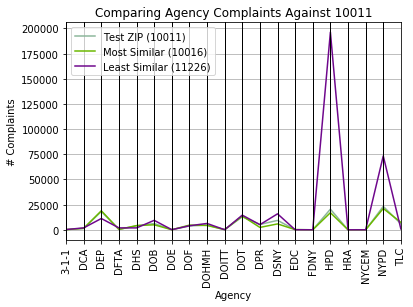

In [14]:
test_10011.t2_lazy_neighbor()

In [15]:
# 11217
test_11217.t1_display_vals()

ZIP code 11217's Complaint Counts By Department...
Department N Complaints
    3-1-1        189.0
      DCA        919.0
      DEP      12499.0
     DFTA        388.0
      DHS        752.0
      DOB       3844.0
      DOE        132.0
      DOF       1675.0
    DOHMH       4088.0
    DOITT         35.0
      DOT      17207.0
      DPR       6039.0
     DSNY      12482.0
      EDC        133.0
     FDNY          0.0
      HPD      13184.0
      HRA          0.0
    NYCEM          0.0
     NYPD      30890.0
      TLC       2246.0


ZIP code most similar to 11217: 11222
ZIP code least similar to 11217: 11226


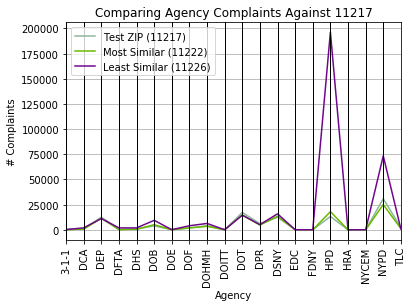

In [16]:
test_11217.t2_lazy_neighbor()

### Data Analysis - Insights/Reflection

Interesting stuff. Looks like the HPD complaints are playing a major role in the similar/different comparisons. For the sake of keeping this workbook at a somewhat reasonable length, I won't pursue the Manhattan formally, but I think it would be interesting to give it a shot. Also, I'd like to see what happens if reorganize the dataset in different ways. What happens if...we make complaints per capita? exclude outlier zips? exclude HPD entirely? 

### Part II - Data Engineering

Ok, how can we make something useful from the data for interested data analysts (DA) and scientists (DS)?

My general thinking is to build a dashboard. That said, I also understand that, at the end of the day, DAs and DSs might just want a clean, compiled dataset with which to work, so I consider the underlying dataset a deliverable in itself. What might the process for building all of this look like?

In AWS land, I'd start with a resourceful EC2 on which I'm running a Jupyter and/or RStudio instance that is capable of working with sizable datasets. The data prep process would be similar to the steps executed above. We would some need weather data, though. There are different sources for these, but you could go with something like OpenWeatherMap's API for getting them. At the end of all of this work, one would have a robust, processed dataset ready to be visualized and to be handed off to anyone wanting to dig deeper into it.  

The destination for this would be a central warehouse. Let's go with Redshift for its columnar orientation -- we're going to be dealing with a good number of rows here, so we can prioritize that. But not such a crazy amount that this process is not so straightforward. 

Now what about the viz? I'm thinking of two: one with a DA focus, one with a DS focus, each of which are useful across positions. 

1) Chloropleth: a viz of NYC broken down by area (zip, borough, etc.) where the color gradient indicates number of complaints and one can toggle through different dates and weather events. I'm also thinking some descriptive stats vizzes would be helpful as secondary information sources: bar plots with average number of complaints per type of weather event per zip/borough, histograms of types of complaints by weather events, etc. It would be totally interactive and dynamic to the user's preferences. 

<img src="https://nycdatascience.com/blog/wp-content/uploads/2016/10/YisongTao_plot1_4.png">

Credit: https://nycdatascience.com/blog/wp-content/uploads/2016/10/YisongTao_plot1_4.png

2) More Developed Parallel Coordinates: I think this viz has promise. It provides a concise look at a dataset that is not concise without sacrificing the granuality of the data. I can imagine this being useful for DSs as they do their EDA and start thinking about their approach to later models. The parallel coordinates would be interactive and dynamic, with options that include per capita complaints, complaints by weather type, outlier detection, etc. This could also be accompanied by secondary vizzes similar to the bar plots, that would help facilitate EDA. 

<img src="https://ncva.itn.liu.se/education-geovisual-analytics/education-geovisual-analytics/1.529628/DashboardWorldScatter-DistPlot-PCPWebI.png">

Credit: https://ncva.itn.liu.se/education-geovisual-analytics/education-geovisual-analytics/1.529628/DashboardWorldScatter-DistPlot-PCPWebI.png 

In terms of how one would go about building this dashboard, I'm envision another EC2 on which Tableau Server lives for developing the dashboard, which can then be web-deployed for central user access. I would want to engage with DAs and DSs at all points in the development process: before, during, and after an initial release. As Data Engineer (DE) I might have different perspectives on how I'd like to approach the data than a DA or DS would have. Since they're the end user, their input along the way is critical. 

Monitoring and maintenance will be a decent focus here. As one can see in the work above, the data are not as pristine as one would hope, but part of the job is handling those realities. Given this, and assuming that this is running and updating daily and automatically, I can think of a number of checks and monitors I'd like to put into place, some of which would be: 

-Raw value checks: checking for any uncleanliness that might challenge any regex/cleaning/standardizing processes we have in place. These could logged and DE could get alerts on any surprises.

-Pre-deploy dashboard checks: did everything in the processing script go as expected (joins, drops, API requests, etc.)? Alerts can also be implemented here. 

-There could also be a formal unit-testing process in place prior to release of the boards. E.g. if we decided `lazy_neighbor` metrics would be good to include in the end-product, we could unit-test that piece of functionality to ensure that it was functioning as expected given tailored input data. 

Another, and one of, if not the ultimate, concern in a DE's work is security, which is something I'm also considering for this project. As I've set it up, all data will be from the public-domain. That said, we would want to do our diligence in locking down our systems as any organization would so as not to compromise what we've developed. I imagine we would have all of the AWS standard security measures in place: IP whitelisting, IAM, all different levels of security groups, securely stored and shared credentials, RDS encryption, etc.

<p>---

I think that covers most of it for Part II, which concludes the task. I look forward to the prospect of discussing my materials with you all. Thank you for your time and consideration.

-TA